<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Arabic POS Tagging </h1></center>

In natural language processing (NLP), **Part of Speech (POS)** refers to **the grammatical category** or syntactic function that a word serves in a sentence. It's a way of categorizing words based on their roles within the structure of a sentence. POS tagging involves assigning a specific label, such as **noun**, **verb**, **adjective**, **adverb**, etc., to each word in a sentence.

Here are some common parts of speech:

| Tag              | Arabic Tag | Description |
| :---------------- | ------: | :---- |
| Noun (N)        |   اسم   | Represents a person, place, thing, or idea. Examples: dog, city, happiness. |
| Verb (V)           |   فعل   | Describes an action or occurrence. Examples: run, eat, sleep. |
| Adjective (ADJ)    |  صفة   | Modifies or describes a noun. Examples: happy, tall, red. |
| Adverb (ADV) |  حال   | Modifies or describes a verb, adjective, or other adverb. Examples: quickly, very, well. |
| Pronoun (PRON) |  ضمير   | Replaces a noun. Examples: he, she, it. |
| Preposition (PREP) |  حرف جر   | Indicates relationships between words, often in terms of time or place. Examples: in, on, under. |
| Conjunction (CONJ) |  اقتران   | Connects words, phrases, or clauses. Examples: and, but, or. |
| Interjection (INTJ) |  تعجب   | Expresses strong emotion. Examples: wow, oh, ouch. |


**POS tagging** is an essential task in NLP because understanding the grammatical structure of a sentence helps machines comprehend the meaning and context of the text. It's particularly useful in applications like text analysis, information retrieval, and language translation. 
in this notebook we will try 2 different solutions : 

### **1- Farasa Model**

### **2- XLM-R Fine-Tuning**

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Import Libraries</h2>

In [ ]:
# !pip install farasa networkx farasapy spacy networkx arabic-reshaper python-bidi transformers accelerate seqeval datasets fsspec
from farasa.pos import FarasaPOSTagger
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from farasa.pos import FarasaPOSTagger
import ast
import requests
from collections import Counter, defaultdict
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from seqeval.metrics import f1_score, accuracy_score
import torch
from torch.nn.functional import cross_entropy
from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import (AutoTokenizer, XLMRobertaForTokenClassification,Trainer, TrainingArguments, AutoConfig,DataCollatorForTokenClassification)

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Farasa Tagger</h1>

**Farasa is the state-of-the-art full-stack package to deal with Arabic Language Processing. It has been developed by Arabic Language Technologies Group at Qatar Computing Research Institute (QCRI) It has a RESTful Web API that you can use through your favorable programming language. It has many packages for different arabic related tasks like POS(part of speech), NER,....etc . you can check test it with live demo  [Farasa](https://farasa.qcri.org/POS/)**

In [ ]:
farasa_pos = FarasaPOSTagger()
Text = 'يُشار إلى أن اللغة العربية'

pos_tagger = farasa_pos.tag(Text)
print("Raw Output:", pos_tagger)

Raw Output: S/S يشار/V إلى/PREP أن/PART ال+ لغ +ة/DET+NOUN+NSUFF-FS ال+ عربي +ة/DET+ADJ+NSUFF-FS E/E


In [ ]:
farasa_pos = FarasaPOSTagger()
text = '''تعتبر التكنولوجيا الحديثة من أبرز الاختراعات التي غيرت وجه العالم في العقود الأخيرة.
 فقد شملت العديد من المجالات مثل الاتصالات، الطب، التعليم، والصناعة. تؤثر هذه التطورات بشكل كبير على حياتنا اليومية، سواء في العمل أو في الترفيه أو في التواصل مع الآخرين '''


pos_tags = farasa_pos.tag(text)
# Split the tagged output into words and their respective POS tags
tagged_words = []
for tag in pos_tags.split():
    if '/' in tag:
        word, pos = tag.split('/', 1)  # Split only on the first '/' to handle cases like "ال+لغ/+ة"
    else:
        word, pos = tag, 'UNKNOWN'  # Handle cases where no '/' is found
    tagged_words.append((word, pos))

df = pd.DataFrame(tagged_words, columns=['Word', 'POS'])
print("POS Tagging Results:")
df.head(15)

POS Tagging Results:


,Word,POS
0,S,S
1,تعتبر,V
2,ال+,UNKNOWN
3,تكنولوجيا,DET+NOUN-MS
4,ال+,UNKNOWN
5,حديث,UNKNOWN
6,+ة,DET+ADJ+NSUFF-FS
7,من,PREP
8,أبرز,NOUN-MS
9,ال+,UNKNOWN


In [ ]:
# Function to redistribute POS tags
def redistribute_pos_tags(tagged_words):
    i = 0
    while i < len(tagged_words):
        if tagged_words[i][1] == 'UNKNOWN':
            # Find the next known POS tag
            j = i + 1
            while j < len(tagged_words) and tagged_words[j][1] == 'UNKNOWN':
                j += 1
            if j < len(tagged_words):
                # Split the combined POS tag
                combined_pos = tagged_words[j][1].split('+')
                # Redistribute the POS tags
                for k in range(i, j):
                    if k - i < len(combined_pos) - 1:
                        tagged_words[k] = (tagged_words[k][0], combined_pos[k - i])
                    else:
                        tagged_words[k] = (tagged_words[k][0], 'UNKNOWN')
                # Update the current known POS tag
                tagged_words[j] = (tagged_words[j][0], combined_pos[-1])
            i = j + 1
        else:
            i += 1
    return tagged_words

# Redistribute POS tags
tagged_words = redistribute_pos_tags(tagged_words)

df = pd.DataFrame(tagged_words, columns=['Word', 'POS'])
print("POS Tagging Results:")
df.head(15)

POS Tagging Results:


,Word,POS
0,S,S
1,تعتبر,V
2,ال+,DET
3,تكنولوجيا,NOUN-MS
4,ال+,DET
5,حديث,ADJ
6,+ة,NSUFF-FS
7,من,PREP
8,أبرز,NOUN-MS
9,ال+,DET


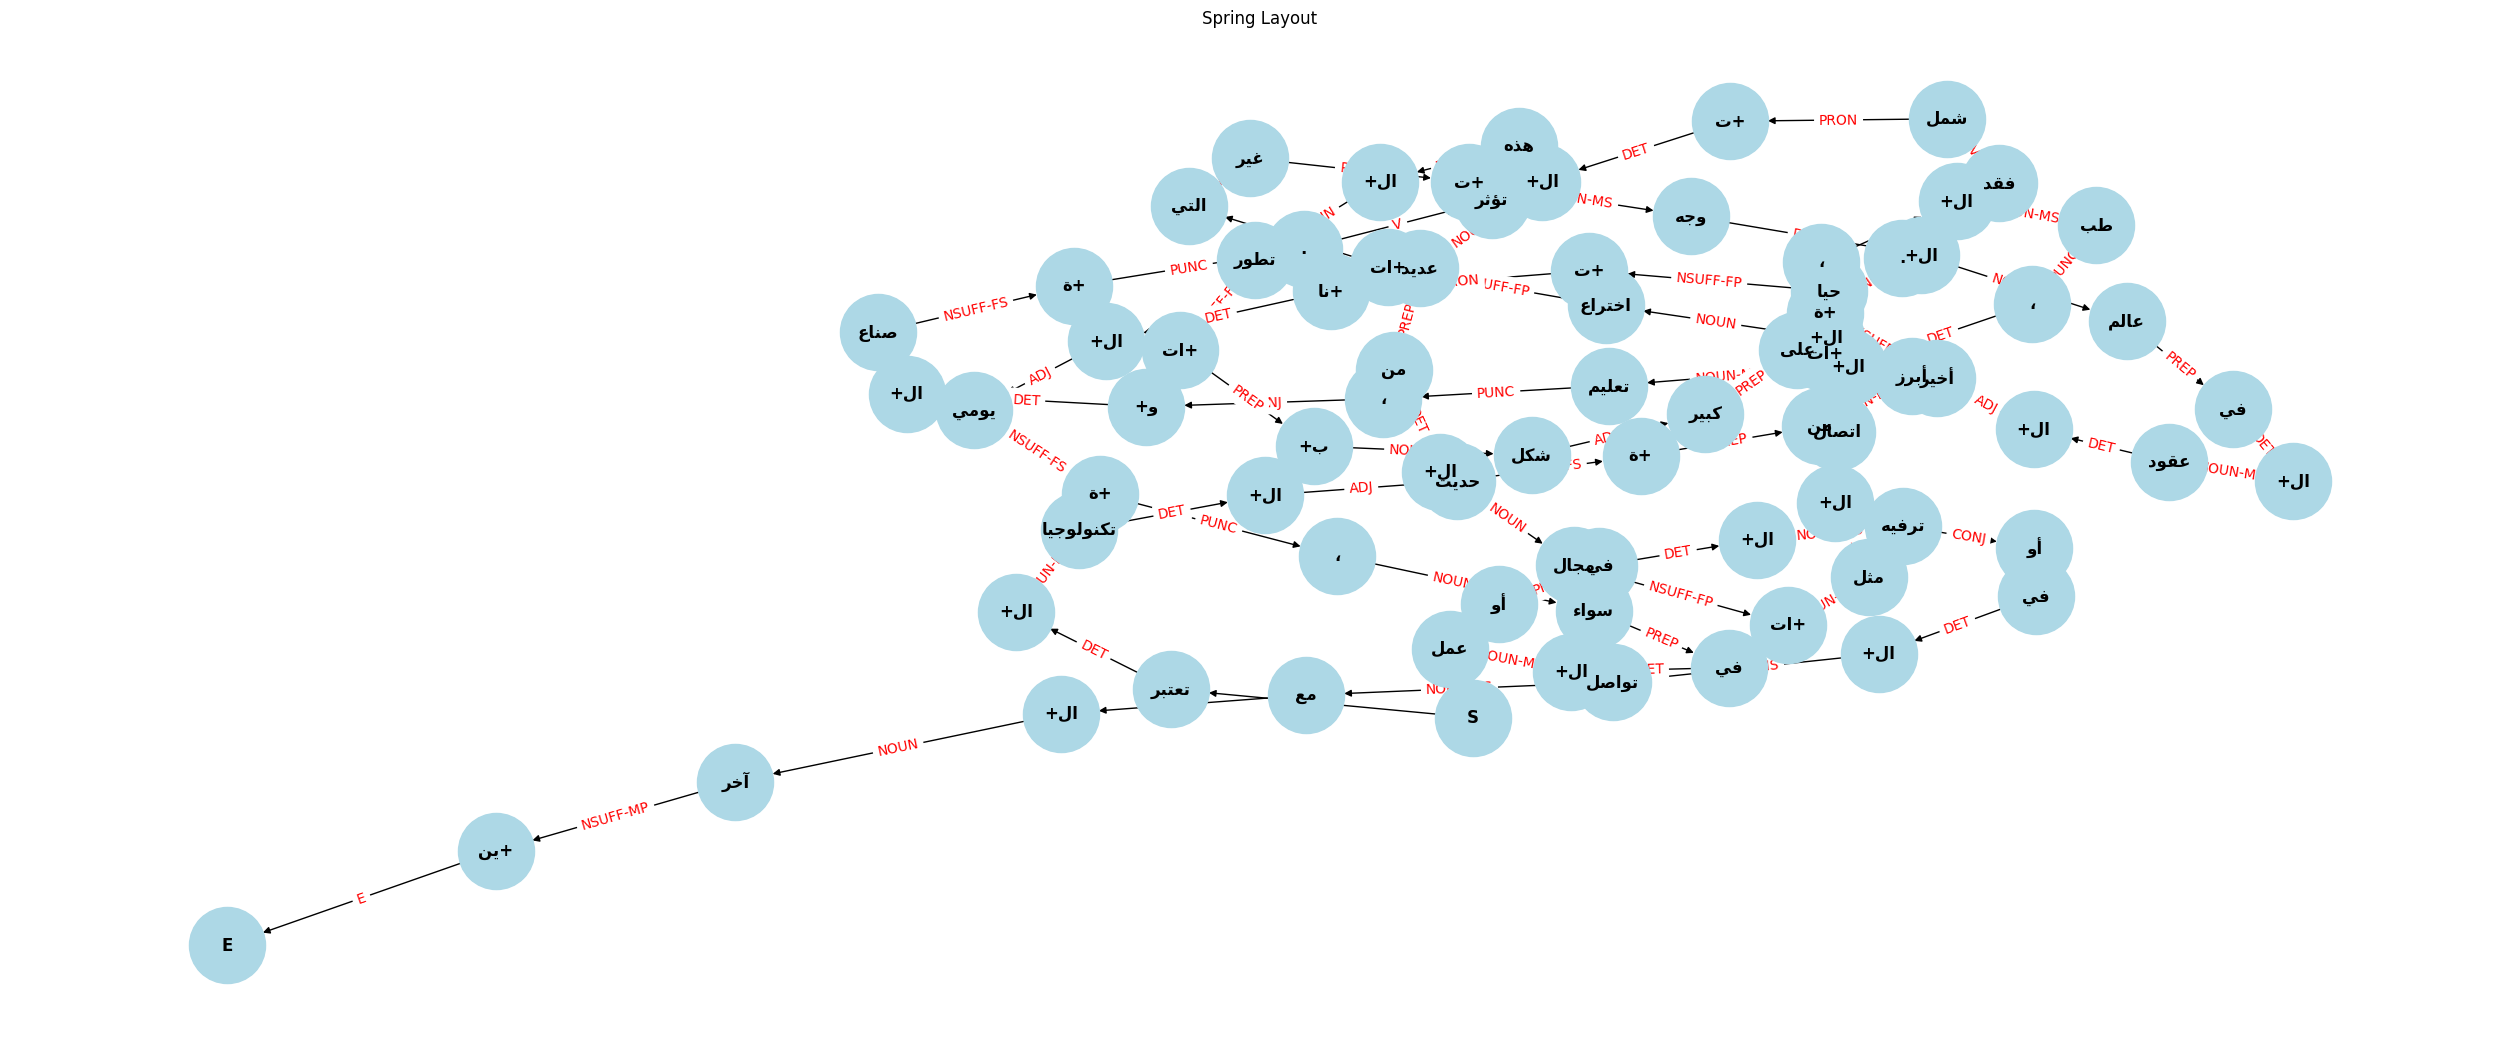

In [ ]:
def visualize_spring_layout(tagged_words):
    G = nx.DiGraph()
    for i, (word, pos) in enumerate(tagged_words):
        reshaped_word = get_display(arabic_reshaper.reshape(word))
        G.add_node(i, word=reshaped_word, pos=pos)
        if i > 0:
            G.add_edge(i-1, i)

    pos_layout = nx.spring_layout(G)
    plt.figure(figsize=(25, 10))
    labels = {i: node['word'] for i, node in G.nodes(data=True)}
    nx.draw(G, pos_layout, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold')
    edge_labels = {(u, v): G.nodes[v]['pos'] for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos_layout, edge_labels=edge_labels, font_color='red')
    plt.title(get_display(arabic_reshaper.reshape("Spring Layout")))
    plt.show()

# Call the function
visualize_spring_layout(tagged_words)

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">XLMR Transformer</h1>

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">EDA</h2>

**we will implement of an Arabic Part-of-Speech (POS) tagging system using the XLM-RoBERTa (XLM-R) model, which is a state-of-the-art multilingual transformer model**
**The [Arabic-PADT UD](https://github.com/UniversalDependencies/UD_Arabic-PADT) treebank is based on the Prague Arabic Dependency Treebank (PADT)**
**It consists of 7,664 sentences (282,384 tokens) and its domain is mainly newswire it also can be downloaded from [Here](http://hdl.handle.net/11858/00-097C-0000-0001-4872-3).**

**we need to know that our data is in CoNLL-U format. The name "CoNLL-U" comes from the CoNLL (Conference on Computational Natural Language Learning) community, which developed the format, and the "U" stands for Universal Dependencies. A CoNLL-U file is a plain text file where each word in a sentence is represented as a line, and each line contains 10 fields separated by tabs. Sentences are separated by blank lines, and additional metadata (e.g., sentence IDs, text) is provided in comment lines starting with #.**

for example here is the first sample from the `ar_padt-ud-test.conllu` file where fields should be separated by tabs:
```
# newdoc id = assabah.20041005.0017
# newpar id = assabah.20041005.0017:p1
# sent_id = assabah.20041005.0017:p1u1
# text = سوريا: تعديل وزاري واسع يشمل 8 حقائب
# orig_file_sentence ASB_ARB_20041005.0017#1
1	سوريا	سُورِيَا	X	X---------	Foreign=Yes	0	root	0:root	SpaceAfter=No|Vform=سُورِيَا|Gloss=Syria|Root=sUr|Translit=sūriyā|LTranslit=sūriyā
2	:	:	PUNCT	G---------	_	1	punct	1:punct	Vform=:|Translit=:
3	تعديل	تَعدِيل	NOUN	N------S1I	Case=Nom|Definite=Ind|Number=Sing	6	nsubj	6:nsubj	Vform=تَعدِيلٌ|Gloss=adjustment,change,modification,amendment|Root=_d_l|Translit=taʿdīlun|LTranslit=tadīl
4	وزاري	وِزَارِيّ	ADJ	A-----MS1I	Case=Nom|Definite=Ind|Gender=Masc|Number=Sing	3	amod	3:amod	Vform=وِزَارِيٌّ|Gloss=ministry,ministerial|Root=w_z_r|Translit=wizārīyun|LTranslit=wizārīy
5	واسع	وَاسِع	ADJ	A-----MS1I	Case=Nom|Definite=Ind|Gender=Masc|Number=Sing	3	amod	3:amod	Vform=وَاسِعٌ|Gloss=wide,extensive,broad|Root=w_s_|Translit=wāsiʿun|LTranslit=wāsi
6	يشمل	شَمِل	VERB	VIIA-3MS--	Aspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Person=3|VerbForm=Fin|Voice=Act	1	parataxis	1:parataxis	Vform=يَشمَلُ|Gloss=comprise,include,contain|Root=^s_m_l|Translit=yašmalu|LTranslit=šamil
7	8	8	NUM	Q---------	NumForm=Digit	6	obj	6:obj	Vform=٨|Translit=8
8	حقائب	حَقِيبَة	NOUN	N------P2I	Case=Gen|Definite=Ind|Number=Plur	7	nmod	7:nmod:gen	Vform=حَقَائِبَ|Gloss=briefcase,suitcase,portfolio,luggage|Root=.h_q_b|Translit=ḥaqāʾiba|LTranslit=ḥaqībat
```

In [ ]:
# Define the links of the dataset files
dataset_splits = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-train.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-test.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-dev.conllu",
}

# These are the standard column names for these `conllu` files
columns = ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]


def get_dataframe_of_split(split):
  
    # Download the datafile
    response = requests.get(dataset_splits[split])
    downloaded_data = response.text  # data saved in string format
    lines = downloaded_data.split('\n') # text data is split into individual lines, as each line either a token (word) or a comment/metadata
    data = [] # store the processed token information.

    # Add a new column to the above columns `SENTENCE_ID` which can tell us which words related to same sentence
    sentence_id = 0
    for line in lines:
        if line.startswith("# sent_id"): # This indicates the start of a new sentence. The sentence_id counter is incremented to track which sentence the current word belongs to.
            sentence_id += 1
        elif line.startswith("#") or line.strip() == "": # comment or blank line
            continue
        else:
            values = line.split('\t')
            values.append(sentence_id) # add sentence_id is appended to the token's values to indicate which sentence it belongs to
            data.append(values)

    df = pd.DataFrame(data, columns=columns + ["SENTENCE_ID"])
    return df

In [ ]:
train_df = get_dataframe_of_split("train")
test_df = get_dataframe_of_split("test")
dev_df = get_dataframe_of_split("dev")
train_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
0,1,برلين,بَرلِين,X,X---------,Foreign=Yes,2,nsubj,2:nsubj,Vform=بَرلِين|Gloss=Berlin|Root=barlIn|Transli...,1
1,2,ترفض,رَفَض,VERB,VIIA-3FS--,Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Per...,0,root,0:root,"Vform=تَرفُضُ|Gloss=reject,refuse|Root=r_f_.d|...",1
2,3,حصول,حُصُول,NOUN,N------S4R,Case=Acc|Definite=Cons|Number=Sing,2,obj,2:obj,"Vform=حُصُولَ|Gloss=acquisition,obtaining,occu...",1
3,4,شركة,شَرِكَة,NOUN,N------S2I,Case=Gen|Definite=Ind|Number=Sing,3,nmod,3:nmod:gen,"Vform=شَرِكَةٍ|Gloss=company,corporation|Root=...",1
4,5,اميركية,أَمِيرِكِيّ,ADJ,A-----FS2I,Case=Gen|Definite=Ind|Gender=Fem|Number=Sing,4,amod,4:amod,Vform=أَمِيرِكِيَّةٍ|Gloss=American|Root='amIr...,1


In [ ]:
test_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
0,1,سوريا,سُورِيَا,X,X---------,Foreign=Yes,0,root,0:root,SpaceAfter=No|Vform=سُورِيَا|Gloss=Syria|Root=...,1
1,2,:,:,PUNCT,G---------,_,1,punct,1:punct,Vform=:|Translit=:,1
2,3,تعديل,تَعدِيل,NOUN,N------S1I,Case=Nom|Definite=Ind|Number=Sing,6,nsubj,6:nsubj,"Vform=تَعدِيلٌ|Gloss=adjustment,change,modific...",1
3,4,وزاري,وِزَارِيّ,ADJ,A-----MS1I,Case=Nom|Definite=Ind|Gender=Masc|Number=Sing,3,amod,3:amod,"Vform=وِزَارِيٌّ|Gloss=ministry,ministerial|Ro...",1
4,5,واسع,وَاسِع,ADJ,A-----MS1I,Case=Nom|Definite=Ind|Gender=Masc|Number=Sing,3,amod,3:amod,"Vform=وَاسِعٌ|Gloss=wide,extensive,broad|Root=...",1


In [ ]:
dev_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
0,1,ميراث,مِيرَاث,NOUN,N------S1I,Case=Nom|Definite=Ind|Number=Sing,6,nsubj,6:nsubj,"Vform=مِيرَاثٌ|Gloss=inheritance,heritage|Root...",1
1,2,ب,بِ,ADP,P---------,AdpType=Prep,3,case,3:case,"SpaceAfter=No|Vform=بِ|Gloss=by,with|Root=bi|T...",1
2,3,300,300,NUM,Q---------,NumForm=Digit,1,nummod,1:nummod,Vform=٣٠٠|Translit=300,1
3,4,الف,أَلف,NUM,QM-----S2R,Case=Gen|Definite=Cons|Number=Sing|NumForm=Word,3,nummod,3:nummod,Vform=أَلفِ|Gloss=thousand|Root='_l_f|Translit...,1
4,5,دولار,دُولَار,NOUN,N------S2I,Case=Gen|Definite=Ind|Number=Sing,4,nmod,4:nmod:gen,Vform=دُولَارٍ|Gloss=dollar|Root=dUlAr|Transli...,1


**As we can see, the train dataset consists of **254400** row and **11** columns. Each row corresponds to one word.**

| Column | Status |
| ------ | ------ |
| ID | Sentence-level units in PADT often correspond to entire paragraphs and they were obtained automatically. Low-level tokenization (whitespace and punctuation) was done automatically and then hand-corrected. Splitting of fused tokens into syntactic words in Arabic is part of morphological analysis. [ElixirFM](http://elixir-fm.sf.net/) was used to provide context-independent options, then these results were disambiguated manually. |
| FORM | The unvocalized surface form is used. Fully vocalized counterpart can be found in the MISC column as Vform attribute. |
| LEMMA | Plausible analyses provided by ElixirFM, manual disambiguation. Lemmas are vocalized. Part of the selection of lemmas was also word sense disambiguation of the lexemes, providing English equivalents (see the Gloss attribute of the MISC column). |
| UPOSTAG | Converted automatically from XPOSTAG (via [Interset](http://ufal.mff.cuni.cz/interset)); human checking of patterns revealed by automatic consistency tests. |
| XPOSTAG | Manual selection from possibilities provided by ElixirFM. |
| FEATS | Converted automatically from XPOSTAG (via Interset); human checking of patterns revealed by automatic consistency tests. |
| HEAD | Original PADT annotation is manual. Automatic conversion to UD; human checking of patterns revealed by automatic consistency tests. |
| DEPREL | Original PDT annotation is manual. Automatic conversion to UD; human checking of patterns revealed by automatic consistency tests. |
| DEPS | &mdash; (currently unused) |
| MISC | Information about token spacing taken from PADT annotation. Additional word attributes provided by morphological analysis (i.e. ElixirFM rules + manual disambiguation): Vform (fully vocalized Arabic form), Translit (Latin transliteration of word form), LTranslit (Latin transliteration of lemma), Root (word root), Gloss (English translation of lemma). |

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Features Selection</h2>

**All these columns are invaluable for our task, I select only the columns that i need to accomplish this task: [sentence_id, id, form, upos]. In addition to changing these columns names to be representative.**

In [ ]:
column_mapper = {
    "SENTENCE_ID": "sentence_id",
    "ID": "id",
    "FORM": "word",
    "UPOS": "tag",
}

train_df = train_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)
test_df = test_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)
dev_df = dev_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)
train_df.head()

,sentence_id,id,word,tag
0,1,1,برلين,X
1,1,2,ترفض,VERB
2,1,3,حصول,NOUN
3,1,4,شركة,NOUN
4,1,5,اميركية,ADJ


**Get the All Unique Labels from `tag` Column**

In [ ]:
unique_labels = train_df["tag"].unique().tolist()
print(f"There are {len(unique_labels)} unique label:\n{unique_labels}")

There are 18 unique label:
['X', 'VERB', 'NOUN', 'ADJ', 'ADP', 'PUNCT', 'NUM', '_', 'PRON', 'SCONJ', 'CCONJ', 'DET', 'PART', 'ADV', 'SYM', 'AUX', 'PROPN', 'INTJ']




### **Summary Table**
| **Tag**  | **Description**                  | **Example (Arabic)** | **Example (English)**           |
|----------|----------------------------------|-----------------------|---------------------------------|
| `X`      | Other                            | سوريا                | Syria                           |
| `VERB`   | Verb                             | ذهب                  | went                            |
| `NOUN`   | Noun                             | طبيب                 | doctor                          |
| `ADJ`    | Adjective                        | جميل                 | beautiful                       |
| `ADP`    | Adposition (Preposition)         | في                   | in                              |
| `PUNCT`  | Punctuation                      | ،                    | comma                           |
| `NUM`    | Numeral                          | ثلاثة                | three                           |
| `_`      | Missing/Undefined                | -                     | -                               |
| `PRON`   | Pronoun                          | هو                   | he                              |
| `SCONJ`  | Subordinating Conjunction        | لأن                  | because                         |
| `CCONJ`  | Coordinating Conjunction         | و                    | and                             |
| `DET`    | Determiner                       | ال                   | the                             |
| `PART`   | Particle                         | قد                   | may                             |
| `ADV`    | Adverb                           | بسرعة                | quickly                         |
| `SYM`    | Symbol                           | %                    | percent                         |
| `AUX`    | Auxiliary Verb                   | كان                  | was                             |
| `PROPN`  | Proper Noun                      | محمد                 | Mohammed                        |
| `INTJ`   | Interjection                     | واو                  | wow                             |

**Convert the Dataset to be Sentence-Based not Word-Based: In this step, I made a simple grouping by `sentence_id` hence each row corresponding to a specific `sentence_id` becomes a single row in the new dataframe.**

In [ ]:
grouped_train_df = train_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()
grouped_test_df = test_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()
grouped_dev_df = dev_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()

# Rename the columns 
agg_column_mapper = {
    "word": "text",
    "tag": "tags"
}

grouped_train_df.rename(columns=agg_column_mapper, inplace=True)
grouped_test_df.rename(columns=agg_column_mapper, inplace=True)
grouped_dev_df.rename(columns=agg_column_mapper, inplace=True)
grouped_train_df.head()

,sentence_id,text,tags
0,1,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO..."
1,2,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT..."
2,3,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[_, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUNCT,..."
3,4,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[_, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB, A..."
4,5,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[_, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NOUN,..."


**As we can see from the above table, we ended up with a row for each sentence with thier corresponfing `text` and `tags` values**

**Saving the Final Dataframe as CSV Files to loading them**

In [ ]:
grouped_train_df.to_csv("train_dataset.csv", index=0)
grouped_test_df.to_csv("test_dataset.csv", index=0)
grouped_dev_df.to_csv("dev_dataset.csv", index=0)

In [ ]:
train_dataset = load_dataset("csv", data_files="/kaggle/working/train_dataset.csv")
test_dataset = load_dataset("csv", data_files="/kaggle/working/test_dataset.csv")
dev_dataset = load_dataset("csv", data_files="/kaggle/working/dev_dataset.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-edbb778da9002f22/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f05deff3e952704c/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a567aab1ee25f6b2/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

### 3.5.1 Convert the `DatasetDict` object to a `Dataset` object
Here I get the `Dataset` object from each `DatasetDict` object to construct a new `DatasetDict` object containing training, development, and testing sets.

In [ ]:
train_dataset = train_dataset["train"]
test_dataset = test_dataset["train"]
dev_dataset = dev_dataset["train"]

dataset = DatasetDict({"train": train_dataset, "test": test_dataset, "dev": dev_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 909
    })
})

**Creating a `ClassLabel` Object for Out Unique POS Tagsfor to handle categorical labels so each one has an index**

In [ ]:
labels = ClassLabel(num_classes=len(unique_labels), names=unique_labels)
labels

ClassLabel(names=['X', 'VERB', 'NOUN', 'ADJ', 'ADP', 'PUNCT', 'NUM', '_', 'PRON', 'SCONJ', 'CCONJ', 'DET', 'PART', 'ADV', 'SYM', 'AUX', 'PROPN', 'INTJ'], id=None)

**Feature Type Correction: In this step, I will correct the type of `text` and `tags` columns as they are currently `strings` and I need them to be of type `lists` for POS Tagging task. The reason is that the data in these columns is stored as string representations of lists, not actual lists so we cant use list operations like indexing , append, ...**

In [ ]:
example = dataset["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

sentence_id: 1
text: ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
tags: ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']


In [ ]:
print(f"type of text column: {type(example['text'])}")
print(f"type of tags column: {type(example['tags'])}")

type of text column: <class 'str'>
type of tags column: <class 'str'>


**To fix this i used the ` ast.literal_eval()` method, which safely evaluates a string containing a Python literal (e.g., a list, tuple, dictionary, etc.) and converts it into the corresponding Python object  package for easily convert `strings` to `lists` using `literal_eval()` method.**

In [ ]:
def convert_columns_to_lists(example):
   
    return {'text': ast.literal_eval(example['text']), 'tags': ast.literal_eval(example['tags'])}

dataset = dataset.map(convert_columns_to_lists)

example = dataset["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

sentence_id: 1
text: ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
tags: ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']


In [ ]:
print(f"type of text column: {type(example['text'])}")
print(f"type of tags column: {type(example['tags'])}")

type of text column: <class 'list'>
type of tags column: <class 'list'>


**i will convert the POS tags from their string representations (e.g., "VERB", "NOUN") into integer indices , as models typically work with numerical data rather than strings.<br>i used ClassLabel object (labels) to map the string tags to their corresponding integer indices and creates a new column called pos_tags to store these indices.**<br>
**Creating a new `pos_tags` Column using `labels` ClassLabel Object**

In [ ]:
def tags2index(example):
     
    return {"pos_tags": labels.str2int(example["tags"])} # contains the integer indices of the POS tags.

dataset = dataset.map(tags2index)  # map every example(row) in the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 909
    })
})

In [ ]:
example = dataset["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

sentence_id: 1
text: ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
tags: ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']
pos_tags: [0, 1, 2, 2, 3, 4, 2, 2, 2, 5, 0, 5, 3]


**Showing the Number of Tags per Split**

In [ ]:
split2freqs = defaultdict(Counter)

for split, ds in dataset.items():
    for row in ds["tags"]:
        for tag in row:
            split2freqs[split][tag] += 1

pd.DataFrame.from_dict(split2freqs, orient="index").T

,train,test,dev
X,13747.0,1380.0,2041.0
VERB,16789.0,2189.0,2318.0
NOUN,74546.0,9547.0,9612.0
ADJ,23498.0,2937.0,2916.0
ADP,33617.0,4528.0,4410.0
PUNCT,17511.0,2052.0,2882.0
NUM,6010.0,779.0,969.0
_,30519.0,3868.0,4022.0
PRON,8533.0,1133.0,1211.0
SCONJ,4368.0,534.0,555.0


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Tokenization</h1>

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">BERT   vs  XLM-R</h3>

In [ ]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
text = "رفضت برلين ان ترفع الحصار من على ايطاليا"

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(f"BERT tokens: \n{bert_tokens}\n")
print(f"XLMR tokens: \n{xlmr_tokens}\n")

BERT tokens: 
['[CLS]', 'ر', '##ف', '##ض', '##ت', 'ب', '##ر', '##ل', '##ي', '##ن', 'ا', '##ن', 'ت', '##ر', '##ف', '##ع', 'ا', '##ل', '##ح', '##ص', '##ا', '##ر', 'م', '##ن', 'ع', '##ل', '##ى', 'ا', '##ي', '##ط', '##ا', '##ل', '##ي', '##ا', '[SEP]']

XLMR tokens: 
['<s>', '▁رفض', 'ت', '▁بر', 'لين', '▁ان', '▁ت', 'رفع', '▁الح', 'صار', '▁من', '▁على', '▁اي', 'طال', 'يا', '</s>']



### **1. What is BERT?**
- **BERT (Bidirectional Encoder Representations from Transformers)** is a transformer-based model developed by Google.
- It is pre-trained on large amounts of **monolingual text** (e.g., English) using two tasks:
  1. **Masked Language Modeling (MLM)**: Randomly masking tokens and predicting them.
  2. **Next Sentence Prediction (NSP)**: Predicting whether two sentences follow each other.
- BERT uses a **WordPiece tokenizer**, which splits words into subword units (e.g., "playing" → "play" + "##ing").
- **Limitation for Arabic**: BERT is primarily trained on English text, and its tokenizer is not optimized for Arabic or other languages with complex morphology.

---

### **2. What is XLM-R?**
- **XLM-R (XLM-RoBERTa)** is a transformer-based model developed by Facebook AI.
- It is an improved version of **XLM (Cross-lingual Language Model)** and is based on **RoBERTa** (a robustly optimized BERT).
- XLM-R is pre-trained on a **massive multilingual corpus** of 100 languages, including Arabic.
- It uses a **SentencePiece tokenizer**, which is more flexible and better suited for languages with complex morphology (like Arabic).
- **Advantage for Arabic**: XLM-R is specifically designed to handle multilingual text, making it more effective for Arabic and other non-English languages.

---

### **3. Tokenization: BERT vs XLM-R**
Tokenization is the process of splitting text into smaller units (tokens) that can be processed by a model. Let’s compare how BERT and XLM-R tokenize the same Arabic sentence:

#### **Input Sentence**
```
"رفضت برلين ان ترفع الحصار من على ايطاليا"
```

#### **BERT Tokenization**
```python
['[CLS]', 'ر', '##ف', '##ض', '##ت', 'ب', '##ر', '##ل', '##ي', '##ن', 'ا', '##ن', 'ت', '##ر', '##ف', '##ع', 'ا', '##ل', '##ح', '##ص', '##ا', '##ر', 'م', '##ن', 'ع', '##ل', '##ى', 'ا', '##ي', '##ط', '##ا', '##ل', '##ي', '##ا', '[SEP]']
```
- **WordPiece Tokenizer**: BERT splits words into smaller subword units, often breaking Arabic words into meaningless fragments.
  - Example: "رفضت" → `['ر', '##ف', '##ض', '##ت']`
  - Example: "برلين" → `['ب', '##ر', '##ل', '##ي', '##ن']`
- **Issues**:
  - Arabic words are often split into **unintuitive subword units**, losing the meaning of the original word.
  - This makes it harder for the model to understand the context and morphology of Arabic text.

#### **XLM-R Tokenization**
```python
['<s>', '▁رفض', 'ت', '▁بر', 'لين', '▁ان', '▁ت', 'رفع', '▁الح', 'صار', '▁من', '▁على', '▁اي', 'طال', 'يا', '</s>']
```
- **SentencePiece Tokenizer**: XLM-R uses a more sophisticated tokenizer that better handles Arabic morphology.
  - Example: "رفضت" → `['▁رفض', 'ت']`
  - Example: "برلين" → `['▁بر', 'لين']`
- **Advantages**:
  - Arabic words are split into **meaningful subword units**, preserving the root and morphology.
  - The tokenizer is trained on a multilingual corpus, making it more effective for Arabic.

---

### **4. Why XLM-R is Better for Arabic**
#### **a. Multilingual Training**
- XLM-R is trained on **100 languages**, including Arabic, making it inherently better at handling Arabic text.
- BERT, on the other hand, is primarily trained on English and struggles with languages like Arabic.

#### **b. Better Tokenization**
- XLM-R’s **SentencePiece tokenizer** is more suited for Arabic morphology, as it preserves the meaning of words by splitting them into meaningful subword units.
- BERT’s **WordPiece tokenizer** often breaks Arabic words into unintuitive fragments, making it harder for the model to understand the text.

#### **c. Contextual Understanding**
- XLM-R’s tokenizer retains the **root and structure** of Arabic words, which is crucial for tasks like POS tagging.
- BERT’s tokenizer loses this information, leading to poorer performance on Arabic tasks.

---

### **6. Conclusion**
- **XLM-R** is chosen over **BERT** for Arabic POS tagging because:
  1. It is **multilingual** and specifically trained on Arabic.
  2. Its **SentencePiece tokenizer** preserves the morphology and meaning of Arabic words.
  3. It provides better **contextual understanding** of Arabic text, leading to superior performance on tasks like POS tagging.

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">XLMRoberta</h1>

**we will use XLMRoberta Model For Token Classification**

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(labels.names)}
tag2index = {tag: idx for idx, tag in enumerate(labels.names)}

In [ ]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels=labels.num_classes, id2label=index2tag, label2id=tag2index)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,config=xlmr_config).to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**example of Tokenization Process**

In [ ]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁رفض,ت,▁بر,لين,▁ان,▁ت,رفع,▁الح,صار,▁من,▁على,▁اي,طال,يا,</s>
Input IDs,0,98747,368,1359,41882,716,746,68581,12011,20573,230,556,5669,76522,2796,2


**As we can see our `xlmr_tokenizer` is working by **SentencePiece Tokenizer**. In addiiton, we can notice that word `رفضت` is splitted into `▁رفض` and `ت` and this means that they should be merged together when returning them back to the original text.**

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Testing Model Before Fine-Tuning</h3>

In [ ]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 16
Shape of outputs: torch.Size([1, 16, 18])


**Obviousliy, the output shape is of size**`[batch_size, sequence_length, number_of_classes]`

In [ ]:
preds = [labels.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁رفض,ت,▁بر,لين,▁ان,▁ت,رفع,▁الح,صار,▁من,▁على,▁اي,طال,يا,</s>
Tags,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX


**As we can see, we get a random tags of `AUX` because the model does not know how to preform the task at our hands.**

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Wrapping All the Steps of Assigning Tags in a Function</h1>

**we will use `tag_text` function to predict POS (Part-of-Speech) tags for a given input text using a pre-trained model and tokenizer. It takes the input text, tokenizes it,<br> passes it through the model, and then maps the model's predictions back to the corresponding POS tags. Finally, it returns the results in a structured format (a pandas DataFrame) showing the tokens and their predicted tags.**

In [ ]:
def tag_text(text, tags, model, tokenizer): 
    """
    Input Parameters:
        text: The input text (a string) for which we want to predict POS tags.
        tags: A ClassLabel object that maps integer indices to their corresponding POS tag names (e.g., 0 → "VERB", 1 → "NOUN").
        model: The pre-trained model (e.g., XLM-R) used for POS tagging.
        tokenizer: The tokenizer associated with the model (e.g., XLM-R tokenizer).
    """
    

    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 18 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token ,dim= 2 specifies that we are taking the argmax along the class dimension(for each token, we select the POS tag with the highest score).
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Text Tokenization</h1>

In [ ]:
example = dataset["test"][0]
tokens, labels = example["text"], example["pos_tags"]

print(f"tokens: {tokens}")
print(f"labels: {labels}")

tokens: ['سوريا', ':', 'تعديل', 'وزاري', 'واسع', 'يشمل', '8', 'حقائب']
labels: [0, 5, 2, 3, 3, 1, 6, 2]


In [ ]:
tokenized_input = xlmr_tokenizer(example["text"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>


In [ ]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>
Word IDs,None,0,1,2,3,3,4,5,5,5,6,7,7,None


**As we can see here using `word_ids()` methods returns the specific word id for each token, hence groupped tokens should have the same `word_id` number (`▁وز` and `اري` have the same word id which is **3** because they are belonging to the same word `(وزاري)` before tokenization).**

In [ ]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx: # handle subword token ( ت for the word رفضت)  , special token ([CLS], [SEP]) 
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>
Word IDs,None,0,1,2,3,3,4,5,5,5,6,7,7,None
Label IDs,-100,0,5,2,3,-100,3,1,-100,-100,6,2,-100,-100
Labels,IGN,X,PUNCT,NOUN,ADJ,IGN,ADJ,VERB,IGN,IGN,NUM,NOUN,IGN,IGN


**Note:**<br>
**Why did I choose **–100** as the ID to mask subword representations? The reason is that in PyTorch the cross-entropy loss class `torch.nn.CrossEntropyLoss` has an attribute called `ignore_index`**<br>
**whose value is **–100**. This index is ignored during training, so we can use it to ignore the tokens associated with consecutive subwords**

**now i will use `tokenize_and_align_labels` func to ensure that the labels (POS tags) are correctly aligned with the tokenized input after the text is split into subword tokens by the tokenizer. <br> This is especially important for models like XLM-R, which use subword tokenization and may split a single word into multiple tokens.**

**it Tokenizes the input text then aligns the POS tags with the tokenized input, ensuring that subword tokens and special tokens are handled correctly and finally adds the aligned labels to the tokenized inputs.**

In [ ]:
def tokenize_and_align_labels(examples):
    
    # truncation to ensure that long sequences are truncated to the max length supported by the model
    # is_split_into_wordsIndicates that the input text is already split into words (necessary for aligning labels).
    tokenized_inputs = xlmr_tokenizer(examples["text"], truncation=True,is_split_into_words=True)
    labels = []

    for idx, label in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            # if word_idx is None (special tokens like [CLS] or [SEP]) or the same as the previous token's word_idx (subword tokens), append -100 to label_ids.
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100) #  special value used to ignore these tokens during loss calculation.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

**Mapping the `tokenize_and_align_labels()` Function to Our Dataset**

In [ ]:
dataset_encoded = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=['text', 'sentence_id', 'pos_tags', 'tags'])
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 909
    })
})

In [ ]:
example = dataset_encoded["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

input_ids: [0, 1359, 41882, 746, 118947, 113825, 21215, 116414, 972, 648, 556, 37416, 58444, 6, 184142, 181, 28414, 250, 44, 7312, 7782, 71374, 44, 3484, 71095, 648, 2]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [-100, 0, -100, 1, -100, 2, 2, 3, -100, -100, 4, 2, -100, 2, -100, 2, -100, -100, 5, 0, -100, -100, 5, 3, -100, -100, -100]


As we can see the dataset is now ready to fine-tune our model on. Each sample consisting of `input_ids`, `attention_mask`, and corresponding `label` for each **input_id**.

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> XLM-R Fine-Tuning</h1>

**we need to create some functions:**

**- `align_predictions()`: This function ensures that the model’s predictions are properly aligned with the ground truth labels, ignoring special tokens and subword tokens**

**- `compute_metrics()`: This function is used in Hugging Face Trainer API to specify which metrics we need to test the model to during training. It takes an argument of type `EvalPrediciton` which contains our **predictions** and corresponding `label_ids`**

In [ ]:
def align_predictions(predictions, label_ids):

    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list


def compute_metrics(eval_pred):

    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)

    return {"f1": f1_score(y_true, y_pred), "accuracy": accuracy_score(y_true, y_pred)}

## **Setting Up Training Arguments, Data Collator, and Trainer**

In [ ]:
num_epochs = 3
batch_size = 2
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-ud-arabic"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error", # Set the logging level ,here it’s set to "error" to only log errors
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",  # means evaluation will happen at the end of each epoch.
    save_steps=1e6,
    weight_decay=0.01, # regularization parameter to prevent overfitting.
    disable_tqdm=False,
    logging_steps=logging_steps)

# Ensures that all sequences in a batch have the same length by adding padding tokens & Handles the alignment of labels and attention masks for token classification tasks.
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    data_collator=data_collator, # to pad sequences.
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["dev"],
    tokenizer=xlmr_tokenizer)

**now let's start our Fine-Tuning**

In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.188700,0.113953,0.958816,0.971454
2,0.090000,0.090725,0.966489,0.976796
3,0.055800,0.091719,0.969978,0.979393


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NUM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: U

TrainOutput(global_step=9114, training_loss=0.11148491115627096, metrics={'train_runtime': 892.0344, 'train_samples_per_second': 20.431, 'train_steps_per_second': 10.217, 'total_flos': 817149256270776.0, 'train_loss': 0.11148491115627096, 'epoch': 3.0})

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Model Testing</h1>

In [ ]:
predictions = trainer.predict(dataset_encoded["test"])
predictions.metrics

/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PUNCT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: U

{'test_loss': 0.10096507519483566,
 'test_f1': 0.9644605235156416,
 'test_accuracy': 0.9749782148636873,
 'test_runtime': 5.0931,
 'test_samples_per_second': 133.513,
 'test_steps_per_second': 66.757}

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Error Analysis</h1>

In [ ]:
# Get the loss and the predicted label for each example (token level)in the passed `batch`.
def forward_pass_with_label(batch):
    
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 18), labels.view(-1), reduction="none")

    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss": loss, "predicted_label": predicted_label}

In [ ]:
test_set = dataset_encoded["test"]
test_set = test_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = test_set.to_pandas()
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 53587, 152, 167390, 94576, 14043, 190644, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 5, 2, 3, -100, 3, 1, -100, -100, 6, ...","[0.0, 0.0005858612, 4.7801783e-05, 0.000339569...","[3, 0, 5, 2, 3, 3, 3, 1, 1, 1, 6, 2, 2, 3, 3, ..."
1,"[0, 109661, 15, 47769, 61501, 13441, 83234, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 5, 2, -100, 2, -100, 5, 5, 1, -100, ...","[0.0, 4.3532653, 4.005352e-05, 0.0005666796, 0...","[2, 2, 5, 2, 2, 2, 2, 5, 5, 1, 1, 2, 3, 0, 0, ..."
2,"[0, 222462, 368, 65, 1333, 38449, 368, 188072,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 7, -100, 10, 1, -100, -100, 2, 9, 0, -1...","[0.0, 2.5868081e-05, 0.0, 4.2318403e-05, 0.000...","[2, 7, 7, 10, 1, 1, 1, 2, 9, 0, 0, 0, 0, 2, 2,..."
3,"[0, 65, 39223, 368, 65, 178339, 114053, 13441,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 7, -100, -100, 10, 1, 2, 2, -100, 3, 9,...","[0.0, 3.1351552e-05, 0.0, 0.0, 4.3033626e-05, ...","[2, 7, 7, 1, 10, 1, 2, 2, 2, 3, 9, 2, 1, 1, 6,..."
4,"[0, 65, 53380, 65, 72039, 188036, 54245, 49510...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 7, -100, 10, 1, 0, 0, -100, 0, 15, 2, -...","[0.0, 2.4437606e-05, 0.0, 4.5894525e-05, 0.000...","[2, 7, 7, 10, 1, 2, 0, 0, 11, 15, 2, 2, 7, 7, ..."


**Converting the Result Into a Human-Readable Format**

In [ ]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["text"] = df["input_tokens"].apply(lambda x: xlmr_tokenizer.convert_tokens_to_string(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,"[0, 53587, 152, 167390, 94576, 14043, 190644, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, X, PUNCT, NOUN, ADJ, IGN, ADJ, VERB, IGN...","[0.0, 0.0005858612, 4.7801783e-05, 0.000339569...","[ADJ, X, PUNCT, NOUN, ADJ, ADJ, ADJ, VERB, VER...","[<s>, ▁سوريا, ▁:, ▁تعديل, ▁وز, اري, ▁واسع, ▁, ...",<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
1,"[0, 109661, 15, 47769, 61501, 13441, 83234, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, X, PUNCT, NOUN, IGN, NOUN, IGN, PUNCT, P...","[0.0, 4.3532653, 4.005352e-05, 0.0005666796, 0...","[NOUN, NOUN, PUNCT, NOUN, NOUN, NOUN, NOUN, PU...","[<s>, ▁دمشق, ▁(, ▁وك, الات, ▁الان, باء, ▁), ▁-...",<s> دمشق ( وكالات الانباء ) - اجرى الرئيس السو...
2,"[0, 222462, 368, 65, 1333, 38449, 368, 188072,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, _, IGN, CCONJ, VERB, IGN, IGN, NOUN, SCO...","[0.0, 2.5868081e-05, 0.0, 4.2318403e-05, 0.000...","[NOUN, _, _, CCONJ, VERB, VERB, VERB, NOUN, SC...","[<s>, ▁واضاف, ت, ▁و, ▁أ, ضاف, ت, ▁المصادر, ▁ان...",<s> واضافت و أضافت المصادر ان مهدي دخل الله رئ...
3,"[0, 65, 39223, 368, 65, 178339, 114053, 13441,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, _, IGN, IGN, CCONJ, VERB, NOUN, NOUN, IG...","[0.0, 3.1351552e-05, 0.0, 0.0, 4.3033626e-05, ...","[NOUN, _, _, VERB, CCONJ, VERB, NOUN, NOUN, NO...","[<s>, ▁و, ذكر, ت, ▁و, ▁ذكرت, ▁وكالة, ▁الان, با...",<s> وذكرت و ذكرت وكالة الانباء السورية ان التع...
4,"[0, 65, 53380, 65, 72039, 188036, 54245, 49510...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, _, IGN, CCONJ, VERB, X, X, IGN, X, AUX, ...","[0.0, 2.4437606e-05, 0.0, 4.5894525e-05, 0.000...","[NOUN, _, _, CCONJ, VERB, NOUN, X, X, DET, AUX...","[<s>, ▁و, عين, ▁و, ▁عين, ▁اللواء, ▁كن, عان, ▁ا...",<s> وعين و عين اللواء كنعان الذي كان رئيسا لجه...


### **Example**

In [ ]:
i = 0
example = df.iloc[i]

print(f"text: {example['text']}\n")
print(f"tokens: {example['input_tokens']}\n")
print(f"label: {example['labels']}\n")
print(f"preds: {example['predicted_label']}\n")

text: <s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>

tokens: ['<s>', '▁سوريا', '▁:', '▁تعديل', '▁وز', 'اري', '▁واسع', '▁', 'يش', 'مل', '▁8', '▁حق', 'ائب', '</s>']

label: ['IGN', 'X', 'PUNCT', 'NOUN', 'ADJ', 'IGN', 'ADJ', 'VERB', 'IGN', 'IGN', 'NUM', 'NOUN', 'IGN', 'IGN']

preds: ['ADJ', 'X', 'PUNCT', 'NOUN', 'ADJ', 'ADJ', 'ADJ', 'VERB', 'VERB', 'VERB', 'NUM', 'NOUN', 'NOUN', 'ADJ']



**Displaying the Result to get Loss for Each Indvidual Word**

In [ ]:
df.reset_index(inplace=True)
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens.head()

,index,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,0,53587,1,X,0.000586,X,▁سوريا,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,152,1,PUNCT,0.000048,PUNCT,▁:,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,167390,1,NOUN,0.00034,NOUN,▁تعديل,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,94576,1,ADJ,0.00483,ADJ,▁وز,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,190644,1,ADJ,0.004566,ADJ,▁واسع,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>


In [ ]:
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head()

,index,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,0,53587,1,X,0.0,X,▁سوريا,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,152,1,PUNCT,0.0,PUNCT,▁:,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,167390,1,NOUN,0.0,NOUN,▁تعديل,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,94576,1,ADJ,0.0,ADJ,▁وز,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,190644,1,ADJ,0.0,ADJ,▁واسع,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>


### **Top 10** Highest Loss Input Tokens

In [ ]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁الم,▁ال,▁بدو,▁ع,▁البد,▁إن,▁الا,▁ت,▁است
count,1800,239,560,11,17,13,86,102,260,69
mean,0.11,0.33,0.14,5.28,3.07,3.92,0.54,0.44,0.15,0.53
sum,205.89,79.17,76.85,58.09,52.22,50.97,46.07,45.39,38.91,36.64


### **Top 10** Highest Loss Labels

In [ ]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
labels,X,PROPN,AUX,PART,SYM,ADV,ADJ,VERB,NOUN,DET,NUM,SCONJ,ADP,PRON,CCONJ,_,PUNCT
count,1380,31,197,226,41,104,2937,2189,9547,623,779,534,4528,1133,1963,3868,2052
mean,1.03,0.6,0.29,0.28,0.21,0.2,0.15,0.1,0.07,0.06,0.03,0.03,0.02,0.01,0.01,0.0,0.0
sum,1425.22,18.62,57.57,62.74,8.48,20.46,449.99,217.97,691.51,39.89,26.11,14.19,74.51,10.43,14.69,6.35,0.19


**We see that `X` token has the **highest average loss**, which means that determining a non part-of-speech token poses a challenge to our model.**

**We can break this down further by plotting the confusion matrix of the token classification.**

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Confusion Matrix</h1>

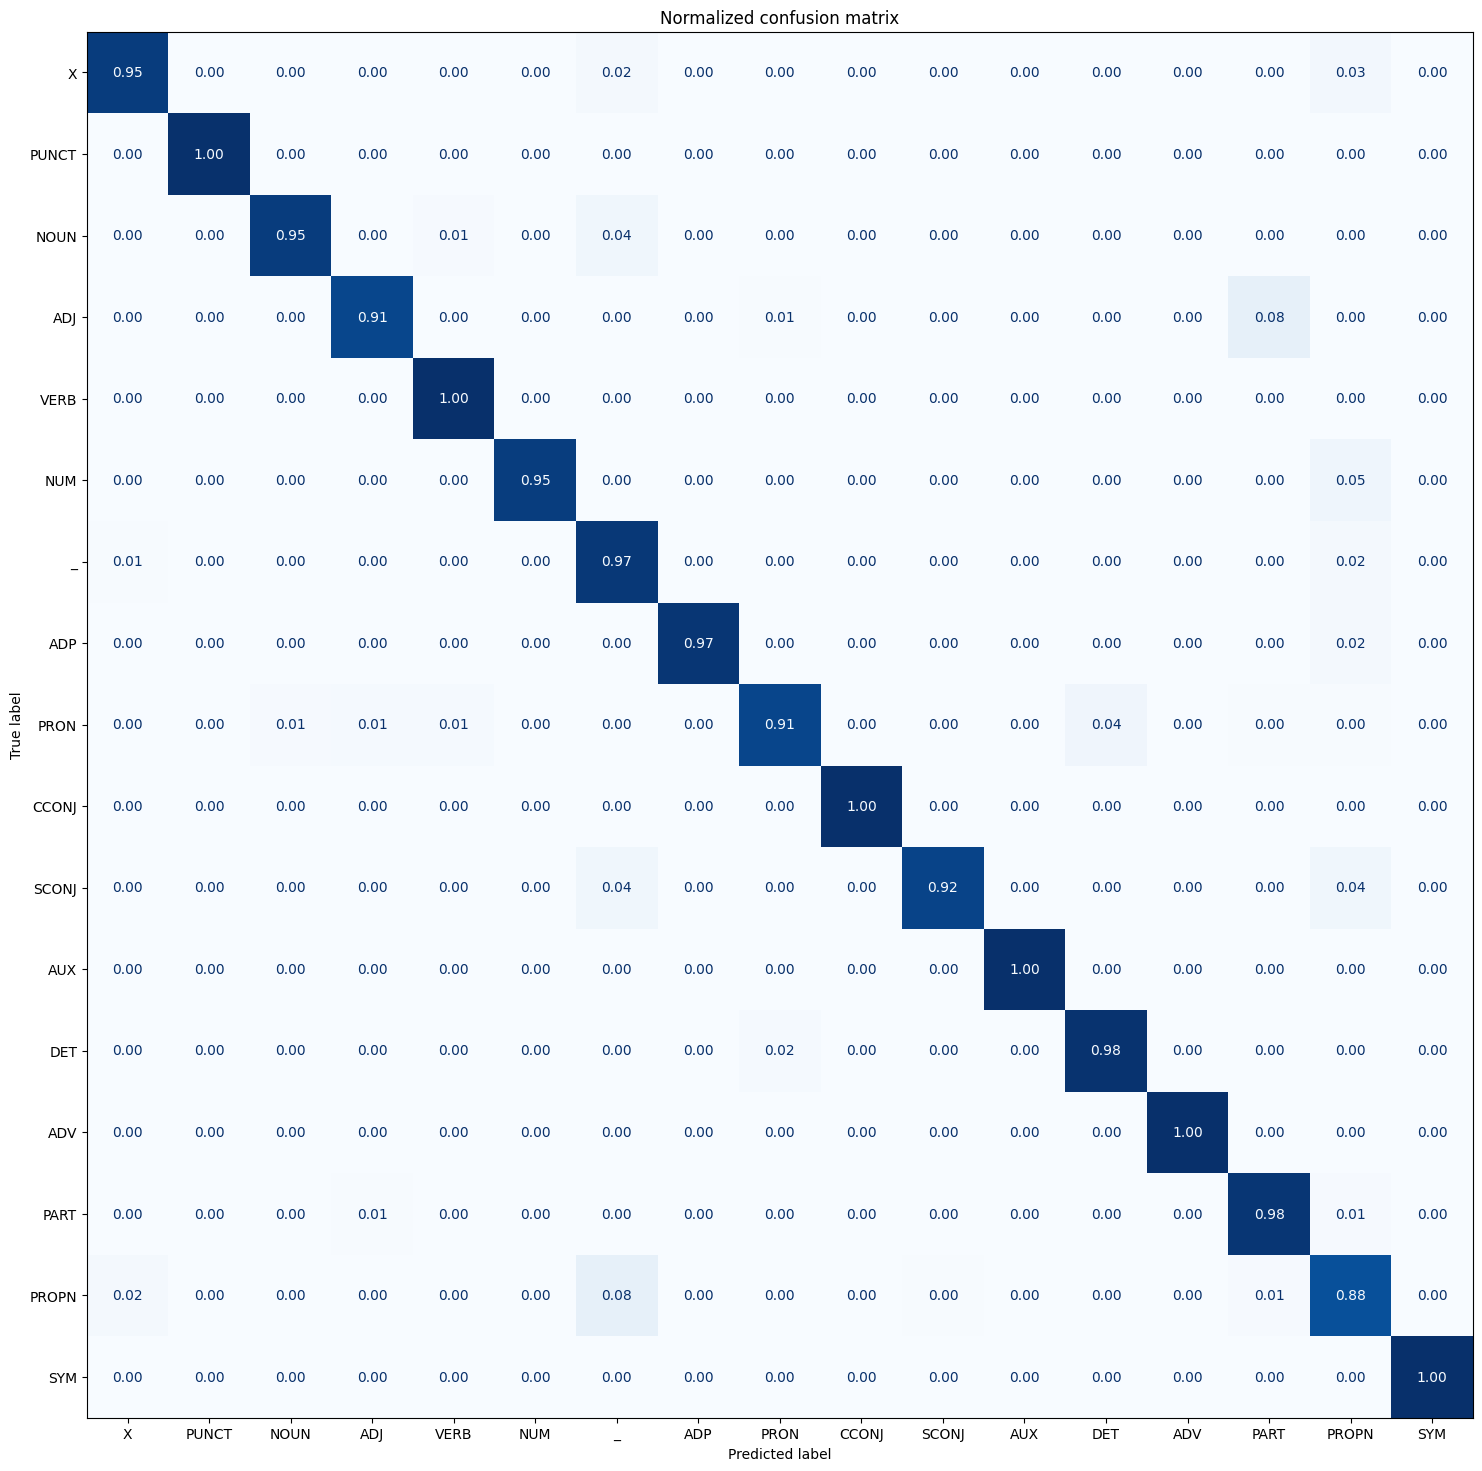

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    
    cm = confusion_matrix(y_true, y_preds, normalize="true")

    _, ax = plt.subplots(figsize=(18, 18))

    ax.set(
         xticks=np.arange(len(labels)),
         yticks=np.arange(len(labels)),
         xticklabels=labels,
         yticklabels=labels
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], df_tokens["labels"].unique().tolist())

## **EDA for **Top 3** Total Loss Examples**

**Now that we’ve examined the errors at the token level, let’s move on and look at **sequences with high losses**. For this calculation, we’ll revisit our “unexploded” DataFrame and calculate the total loss by summing <br>over the loss per token. To do this, let’s first write a function that helps us display the token sequences with the labels and the losses.**

In [ ]:
def get_samples(df):

    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, _ in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")

        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                                "preds": preds, "losses": losses}).T
        yield df_tmp

        
# get the top 3 highest loss examples in our dataset 
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
tokens,▁وأضاف,▁و,▁أ,ضاف,▁نحن,▁في,▁حالة,▁ان,ق,راض,...,▁البد,و,▁من,▁ال,وجود,▁على,▁الأرض,▁,.,</s>
labels,_,CCONJ,VERB,IGN,X,ADP,NOUN,NOUN,IGN,IGN,...,ADJ,IGN,ADP,NOUN,IGN,ADP,NOUN,PUNCT,IGN,IGN
preds,_,CCONJ,VERB,VERB,X,ADP,NOUN,NOUN,NOUN,NOUN,...,NOUN,NOUN,ADP,NOUN,NOUN,ADP,NOUN,PUNCT,PUNCT,NOUN
losses,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.06,0.00,0.00,...,6.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
tokens,▁لا,▁شك,▁في,▁ان,▁هناك,▁من,▁ي,رد,ّ,▁على,...,▁ما,▁نفع,له,▁نفع,ل,▁ه,▁اليوم,▁,.,</s>
labels,PART,NOUN,ADP,SCONJ,ADV,DET,VERB,IGN,IGN,ADP,...,DET,_,IGN,VERB,IGN,PRON,NOUN,PUNCT,IGN,IGN
preds,PART,NOUN,ADP,SCONJ,ADV,DET,VERB,VERB,VERB,ADP,...,DET,_,_,VERB,VERB,PRON,NOUN,PUNCT,PUNCT,ADJ
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
tokens,▁بالا,مس,▁ب,▁الأم,س,▁،,▁سمعت,▁احد,▁الخبر,اء,...,▁ولا,▁و,▁لا,▁يجد,ون,▁الدو,اء,▁,.,</s>
labels,_,IGN,ADP,NOUN,IGN,PUNCT,VERB,NOUN,NOUN,IGN,...,_,CCONJ,PART,VERB,IGN,NOUN,IGN,PUNCT,IGN,IGN
preds,_,_,ADP,NOUN,NOUN,PUNCT,VERB,NOUN,NOUN,NOUN,...,_,CCONJ,PART,VERB,VERB,NOUN,NOUN,PUNCT,PUNCT,ADJ
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.01,0.00,...,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Conclusion</h1>

**It seems that there are some mistakes in the original annotation of the data,for example the word `نحن` was originally labeled as `X` which is incorrect and it should be `PRON`, `.` was originally labeled as `IGN` and it should be `PUNCT`.**

**With this simple analysis, I've identified some weaknesses in both the model and the dataset. Typically, I should solve these problems by refining the dataset and retrain the model again, however, the process of refining the dataset is time-consuming and I think that 97% accuracy is a great result by the way.**